<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/crypto_funding_rsims_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo of crypto futures funding in rsims

**TODO:** Important check on accounting - what happens when something drops out of our tradeable universe?

rsims can now do crypto perpetual futures simulations that account for funding!

This notebook provides a demonstration of how to simulate a simple carry strategy on Binance perpetuals.

It also shows how rsims performs the cash accounting under the hood, and performs a quick check that funding accruals match what we would expect.

The use case for rsims is when you want to quickly explore various execution trade-offs, especially around turnover and doing the minimum amount of trading to harness the edge.

For this reason, rsims performs its simulations quickly. But there's a trade-off: some opinionated data wrangling upstream. But the inputs to rsims are not far from the outputs of a quant research process, so it's not a bad trade off.

rsims also requires the user to correctly align prices, weights, and funding rates. Specifically, weights should be date-aligned with the prices at which you assume you trade into them. This means that you will generally need to lag your weights or your signals upstream.

This article also demonstrates the data wrangling required for rsims, and a simple trick to ensure correct alignment of prices and target weights.

**Assumptions and considerations**:   

- Won't allow a position that would be rejected by the exchange/broker given user-
supplied margin requirements. Positions that would be rejected are
automatically scaled back.
- Similarly, force liquidates the portfolio to conform with margin
requirements (ie simulates a margin call).  
- Contracts are liquidated in equal proportion, which may not be how an exchange/broker actually performs this operation.  
- User-specified leverage should be embedded in the target weights values.
- Currently only fixed commission models are implemented.
- Actual positions are determined using a trade buffer approach: when an
actual portfolio weight differs from its target weight by `trade_buffer` or
more, rebalance back to the target weight plus or minus the `trade_buffer`
depending on which side of the target weight the current weight lies.
- Uses a user-supplied constant margin requirement for all assets in the
portfolio (asset-wise margin requirements to be implemented later)
- Currently assumes all contracts have the same quote asset. So for now, don't mix for example USD-M and coin-M Binance futures
- Doesn't consider interst on cash balance (coming later)

## Crypto perpetual futures pnl accounting

Futures PnL accounting is a little different to stocks or other real assets.

Specifically, it's generally cash-based:  
- You put up margin or collateral to open a futures position, giving you a certain exposure.
- The value of your exposure changes as the market moves.
- You see these changes as a change in your cash balance.
- Traditional futures have a daily settlement where cash changes hands.
- Crypto futures generally do this more in real time where your unrealised gains/losses are reflected in your cash balance in real time.
- Compare this to a real asset like a stock: you buy it, it's value changes, and this is reflected as a change in the value of the asset itself.
- rsims does this cash accounting by applying gains/losses (both realised and unrealised) to the cash balance at the end of the period - which is a simplification.

In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = TRUE, extra_libraries = c("roll"), extra_dependencies = c())

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Using 2  CPUs for package installation

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




bit        (4.0.4 -> 4.0.5) [CRAN]
tidyselect (1.2.0 -> 1.2.1) [CRAN]


Installing 2 packages: bit, tidyselect

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



processx (3.8.3    -> 3.8.4 ) [CRAN]
callr    (3.7.3    -> 3.7.6 ) [CRAN]
pkgbuild (1.4.3    -> 1.4.4 ) [CRAN]
openssl  (2.0.6    -> 2.1.1 ) [CRAN]
curl     (5.0.2    -> 5.2.1 ) [CRAN]
gargle   (1.5.1    -> 1.5.2 ) [CRAN]
digest   (0.6.34   -> 0.6.35) [CRAN]
zip      (2.3.0    -> 2.3.1 ) [CRAN]
arrow    (13.0.0.1 -> 15.0.1) [CRAN]
── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpbduMRs/remotes14a244e2d44/RWLab-rwRtools-88f4072/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘rwRtools_0.1.67.tar.gz’

highr       (0.9   -> 0.10 ) [CRAN]
sass        (0.4.8 -> 0.4.9) [CRAN]
xfun        (0.41  -> 0.43 ) [CRAN]
tinytex     (0.49  -> 0.50 ) [CRAN]
htmltools   (0.5.7 -> 0.5.8) [CRAN]
bslib       (0.6.1 -> 0.7.0) [CRAN]
textshap

In [2]:
# snippet: rw data auth v.0.1
rwlab_data_auth()

Authorization successful!

In [3]:
perps <- rwRtools::crypto_get_binance_perps_1h()
funding <- rwRtools::crypto_get_binance_perps_funding()

ℹ Downloading binance_perps_1h.feather

✔ Saved binance_perps_1h.feather to binance/binance_perps_1h.feather  ( 466.9 M…





File successfully transferred


ℹ Downloading binance_perps_funding.feather

✔ Saved binance_perps_funding.feather to binance/binance_perps_funding.feather …





File successfully transferred


In [4]:
head(perps)
head(funding)

Ticker,Datetime,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
BTCUSDT,2019-09-08 17:00:00,10000.00,10000.00,10000.00,10000.00,0.002,20,2,0.001,10.0000
BTCUSDT,2019-09-08 18:00:00,10000.00,10000.00,10000.00,10000.00,0.000,0,0,0.000,0.0000
BTCUSDT,2019-09-08 19:00:00,10344.77,10357.53,10337.43,10340.12,471.659,4879792,562,0.000,0.0000
BTCUSDT,2019-09-08 20:00:00,10340.12,10368.64,10334.54,10351.42,583.271,6037733,731,0.034,351.9712
BTCUSDT,2019-09-08 21:00:00,10351.42,10391.90,10324.77,10391.90,689.759,7136799,827,0.004,41.3850
BTCUSDT,2019-09-08 22:00:00,10392.59,10412.65,10375.58,10375.58,675.394,7020273,821,0.000,0.0000


Ticker,funding_time,funding_rate
<chr>,<dttm>,<dbl>
BTCUSDT,2019-09-10 08:00:00,1e-04
BTCUSDT,2019-09-10 16:00:00,1e-04
BTCUSDT,2019-09-11 00:00:00,1e-04
BTCUSDT,2019-09-11 08:00:00,1e-04
BTCUSDT,2019-09-11 16:00:00,1e-04
BTCUSDT,2019-09-12 00:00:00,1e-04


In [5]:
# worth checking that R hasn't converted your timezones to the local timezone
head(perps$Datetime, 1)
head(funding$funding_time, 1)

[1] "2019-09-08 17:00:00 UTC"

[1] "2019-09-10 08:00:00 UTC"

In [6]:
Sys.getenv('TZ')
Sys.timezone()

[1] ""

[1] "Etc/UTC"

In [7]:
# if not UTC, you need to change Renviron.site with `system` commands and restart runtime. But UTC should be default for Colab.
# if doing this outside of colab, change your .Renviron TZ variable, or use Sys.setenv()

In [8]:
# The funding_time may not always fall exactly on the hour. So you'll want to truncate it if you need to join it on a datetime field.
funding %>%
  mutate(Datetime = lubridate::floor_date(lubridate::as_datetime(funding_time), 'hour')) %>%
  select(-funding_time) %>%
  left_join(perps, by = c("Ticker", "Datetime")) %>%
  head()

Ticker,funding_rate,Datetime,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
<chr>,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
BTCUSDT,1e-04,2019-09-10 08:00:00,10271.93,10286.15,10247.20,10256.08,374.454,3843723,355,332.883,3417047
BTCUSDT,1e-04,2019-09-10 16:00:00,10172.13,10237.41,10172.13,10225.40,306.303,3126934,353,192.995,1970610
BTCUSDT,1e-04,2019-09-11 00:00:00,10094.27,10293.11,10090.62,10142.52,390.557,3974040,427,269.700,2744288
BTCUSDT,1e-04,2019-09-11 08:00:00,10068.41,10074.32,10004.26,10005.18,268.074,2691880,333,219.639,2205226
BTCUSDT,1e-04,2019-09-11 16:00:00,9992.18,10110.21,9934.11,10044.87,643.320,6451662,947,471.630,4733026
BTCUSDT,1e-04,2019-09-12 00:00:00,10163.06,10205.46,10141.11,10155.22,685.695,6968518,784,555.634,5647154


Positive funding: longs pay shorts  
Negative funding: shorts pay longs  

Do we need to lead or lag the funding rate for purposes of rsims??
rsims date-aligns the price and the weight at the time you trade into the weight. So you need to lag your weights wrt to price (calculate weights based on current close, assume you trade into them at the next close).

Funding accrues on that position at the next close - so you need to lead the funding rate to properly align for the purposes of an rsims backtest.  

In [9]:
# make a daily series of perp prices and funding rates - requires some data wrangling
daily <- perps %>%
  # generally will want to left join funding onto perps, or do a full join, since funding may only occur on the 8-hours, not the hour.
  left_join(
  funding %>%
    mutate(Datetime = lubridate::floor_date(lubridate::as_datetime(funding_time), 'hour')) %>%
    select(-funding_time),
  by = c("Ticker", "Datetime")
  ) %>%
  mutate(Date = lubridate::as_date(Datetime)) %>%
  # need to lead the funding rate to align it properly with prices - essentially this aligns funding with the closing price given by a timestamp.
  # also change the sign of the funding rate so that we have funding to long positions - easier to work with
  group_by(Ticker) %>%
  mutate(funding_rate = lead(-funding_rate)) %>%
  group_by(Ticker, Date) %>%
  arrange(Date) %>%
  summarise(
    open = first(Open),
    high = max(High),
    low = min(Low),
    close = last(Close),
    dollar_volume = sum(`Quote asset volume`),
    num_trades = sum(`Number of trades`),
    taker_buy_volume = sum(`Taker buy base asset volume`),
    taker_buy_quote_volumne = sum(`Taker buy quote asset volume`),
    # total funding for the day is the sum of funding accrued
    # coalesce replaces NA with 0
    funding_rate = sum(coalesce(funding_rate, 0))
  ) %>%
  ungroup() %>%
  arrange(Date, Ticker)

  daily %>% head

`summarise()` has grouped output by 'Ticker'. You can override using the
`.groups` argument.


Ticker,Date,open,high,low,close,dollar_volume,num_trades,taker_buy_volume,taker_buy_quote_volumne,funding_rate
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
BTCUSDT,2019-09-08,10000.00,10412.65,10000.00,10391.63,32096300,3754,0.039,4.033562e+02,0e+00
BTCUSDT,2019-09-09,10391.63,10475.54,10077.22,10307.00,152447210,11296,5452.451,5.619740e+07,0e+00
BTCUSDT,2019-09-10,10307.00,10382.97,9940.87,10102.02,92717645,10089,6395.462,6.552636e+07,-3e-04
BTCUSDT,2019-09-11,10094.27,10293.11,9884.31,10159.55,109786236,13811,7724.442,7.784116e+07,-3e-04
BTCUSDT,2019-09-12,10163.06,10450.13,10042.12,10415.13,159494237,20060,10117.798,1.031607e+08,-3e-04
BTCUSDT,2019-09-13,10414.96,10440.55,10153.51,10341.34,198205402,29249,9717.128,1.000831e+08,-3e-04


Check: simulate a strategy that is long BTC from 8 Feb 2024 for a set period of time and check that funding matches expected.

We should start accruing funding from the 9th.

Note that if you want to use leverage, embed it in the weights.

In [10]:
backtest_df <- daily %>%
  filter(Ticker == "BTCUSDT") %>%
  filter(Date >= "2024-02-05", Date < "2024-02-13") %>%
  mutate(weight = case_when(Date >= as_date("2024-02-08") ~ 1, TRUE ~ 0))

head(backtest_df)

Ticker,Date,open,high,low,close,dollar_volume,num_trades,taker_buy_volume,taker_buy_quote_volumne,funding_rate,weight
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
BTCUSDT,2024-02-05,42570.3,43580.0,42235.1,42692.9,10308099592,3020351,120655.29,5168353035,-0.00030000,0
BTCUSDT,2024-02-06,42692.9,43378.8,42559.8,43079.1,8429315913,2349996,97614.64,4195174982,-0.00024250,0
BTCUSDT,2024-02-07,43079.1,44388.0,42763.4,44326.2,10954644814,2929944,130579.30,5675987977,-0.00023679,0
BTCUSDT,2024-02-08,44326.3,45600.0,44306.8,45269.1,13472865469,3448195,150413.12,6761188132,-0.00012285,1
BTCUSDT,2024-02-09,45269.2,48230.3,45218.1,47116.1,24408544253,5650447,266454.92,12508255349,-0.00027842,1
BTCUSDT,2024-02-10,47116.1,48189.6,46836.4,47732.6,8517076446,2285021,91198.27,4324631271,-0.00030000,1


In [11]:
# get weights as a wide matrix
# note that date column will get converted to unix timestamp
backtest_weights <- backtest_df %>%
  pivot_wider(id_cols = Date, names_from = Ticker, values_from = c(close, weight)) %>%  # pivot wider guarantees prices and weight are date aligned
  select(Date, starts_with("weight")) %>%
  data.matrix()

# NA weights should be zero
backtest_weights[is.na(backtest_weights)] <- 0

head(backtest_weights, c(5, 5))

# get prices as a wide matrix
# note that date column will get converted to unix timestamp
backtest_prices <- backtest_df %>%
  pivot_wider(id_cols = Date, names_from = Ticker, values_from = c(close, weight)) %>%  # pivot wider guarantees prices and weight are date aligned
  select(Date, starts_with("close_")) %>%
  data.matrix()

head(backtest_prices, c(5, 5))

# get funding as a wide matrix
# note that date column will get converted to unix timestamp
backtest_funding <- backtest_df %>%
  pivot_wider(id_cols = Date, names_from = Ticker, values_from = c(close, funding_rate)) %>%  # pivot wider guarantees prices and funding_returns_simple are date aligned
  select(Date, starts_with("funding_rate_")) %>%
  data.matrix()

head(backtest_funding, c(5, 5))

Date,weight_BTCUSDT
19758,0
19759,0
19760,0
19761,1
19762,1


Date,close_BTCUSDT
19758,42692.9
19759,43079.1
19760,44326.2
19761,45269.1
19762,47116.1


Date,funding_rate_BTCUSDT
19758,-0.00030000
19759,-0.00024250
19760,-0.00023679
19761,-0.00012285
19762,-0.00027842


In [12]:
# cost-free, no trade buffer
# simulation parameters
initial_cash <- 10000
capitalise_profits <- FALSE  # remain fully invested?
trade_buffer <- 0.
commission_pct <- 0.
margin <- 0.05

# simulation
results_df <- fixed_commission_backtest_with_funding(
  prices = backtest_prices,
  target_weights = backtest_weights,
  funding_rates = backtest_funding,
  trade_buffer = trade_buffer,
  initial_cash = initial_cash,
  margin = margin,
  commission_pct = commission_pct,
  capitalise_profits = capitalise_profits
  ) %>%
  mutate(ticker = str_remove(ticker, "close_")) %>%
  # remove coins we don't trade from results
  drop_na(Value)

In [13]:
results_df

ticker,Date,Close,Position,Value,Margin,Funding,PeriodPnL,Trades,TradeValue,Commission,MarginCall,ReducedTargetPos
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BTCUSDT,2024-02-05,42692.9,0.000000e+00,0.000,0,0.000000,0.0000,0.000000000,0.0000,0,0,0
Cash,2024-02-05,0.0,1.000000e+04,10000.000,0,0.000000,0.0000,0.000000000,0.0000,0,0,0
BTCUSDT,2024-02-06,43079.1,0.000000e+00,0.000,0,0.000000,0.0000,0.000000000,0.0000,0,0,0
Cash,2024-02-06,0.0,1.000000e+04,10000.000,0,0.000000,0.0000,0.000000000,0.0000,0,0,0
BTCUSDT,2024-02-07,44326.2,0.000000e+00,0.000,0,0.000000,0.0000,0.000000000,0.0000,0,0,0
Cash,2024-02-07,0.0,1.000000e+04,10000.000,0,0.000000,0.0000,0.000000000,0.0000,0,0,0
BTCUSDT,2024-02-08,45269.1,2.209012e-01,10000.000,500,0.000000,0.0000,0.220901233,10000.0000,0,0,0
Cash,2024-02-08,0.0,9.500000e+03,9500.000,0,0.000000,0.0000,0.000000000,0.0000,0,0,0
BTCUSDT,2024-02-09,47116.1,2.122417e-01,10000.000,500,-2.897797,405.1068,-0.008659557,-408.0046,0,0,0


**TODO:**

- Funding reconciles
- Make sure pnl reconciles
- Unit test

We trade into BTC perp at the close on the 8th. Our position was 0.2209 BTCUSDT and our execution price was 45269.10.

We pay funding on the 9th. We pay funding on the position we traded into on the 8th at the funding rate for the 9th, using the closing price on the 9th (47116.10) to calculate the value of our position.

(Notice that we pay funding on the value of our position at the closing price on the 9th. This hides the detail of what happened intra day - funding was paid three times. This is not a limitation of rsims - it's because we resampled our data to daily.)

At the close on the 9th, we sell some perp to trade back to our target weight. Our position is now 0.21224 BTCUSDT.

On the 10th, we pay funding on this position with its value calculted using the closing price on the 10th.

Let's make sure this reconciles correctly with the funding in our raw data:

In [14]:
# get funding accrued each day from raw funding data
perps %>%
  # generally will want to left join funding onto perps, or do a full join, since funding may only occur on the 8-hours, not the hour.
  left_join(
  funding %>%
    mutate(Datetime = lubridate::floor_date(lubridate::as_datetime(funding_time), 'hour')) %>%
    select(-funding_time),
  by = c("Ticker", "Datetime")
  ) %>%
  # filter the data we need
  filter(Ticker == "BTCUSDT") %>%
  mutate(Date = lubridate::as_date(Datetime)) %>%
  filter(Date >= "2024-02-05") %>%
  # need to lead the funding rate to align it properly with prices - essentially this aligns funding with the closing price given by a timestamp.
  # also change the sign of the funding rate so that we have funding to long positions - easier to work with
  group_by(Ticker) %>%
  mutate(funding_rate = lead(-funding_rate)) %>%
  group_by(Ticker, Date) %>%
  arrange(Date) %>%
  summarise(
    close = last(Close),
    # total funding for the day is the sum of funding accrued
    # coalesce replaces NA with 0
    funding_rate = sum(coalesce(funding_rate, 0))
  ) %>%
  group_by(Date) %>%
  summarise(funding_rate = sum(coalesce(funding_rate, 0)))

`summarise()` has grouped output by 'Ticker'. You can override using the
`.groups` argument.


Date,funding_rate
<date>,<dbl>
2024-02-05,-0.00030000
2024-02-06,-0.00024250
2024-02-07,-0.00023679
2024-02-08,-0.00012285
2024-02-09,-0.00027842
2024-02-10,-0.00030000
2024-02-11,-0.00030000
2024-02-12,-0.00030000
2024-02-13,-0.00030000


In [15]:
# funding accrued on the 9th: funding rate on the 9th x position traded into on the 8th x value of position at the close on the 9th
-0.00027842 * 0.2209012 * 47116.1
# funding accrued on the 10th
-0.0003 * 0.2122417 * 47732.6

[1] -2.897796

[1] -3.039254

Looks like we got the results we expected.

In [16]:
# list of stablecoins from defi llama
url <- "https://stablecoins.llama.fi/stablecoins?includePrices=true"
response <- httr::GET(url)
stables <- response %>%
  httr::content(as = "text", encoding = "UTF-8") %>%
  jsonlite::fromJSON(flatten = TRUE) %>%
  pluck("peggedAssets") %>%
  pull(symbol)

# sort(stables)

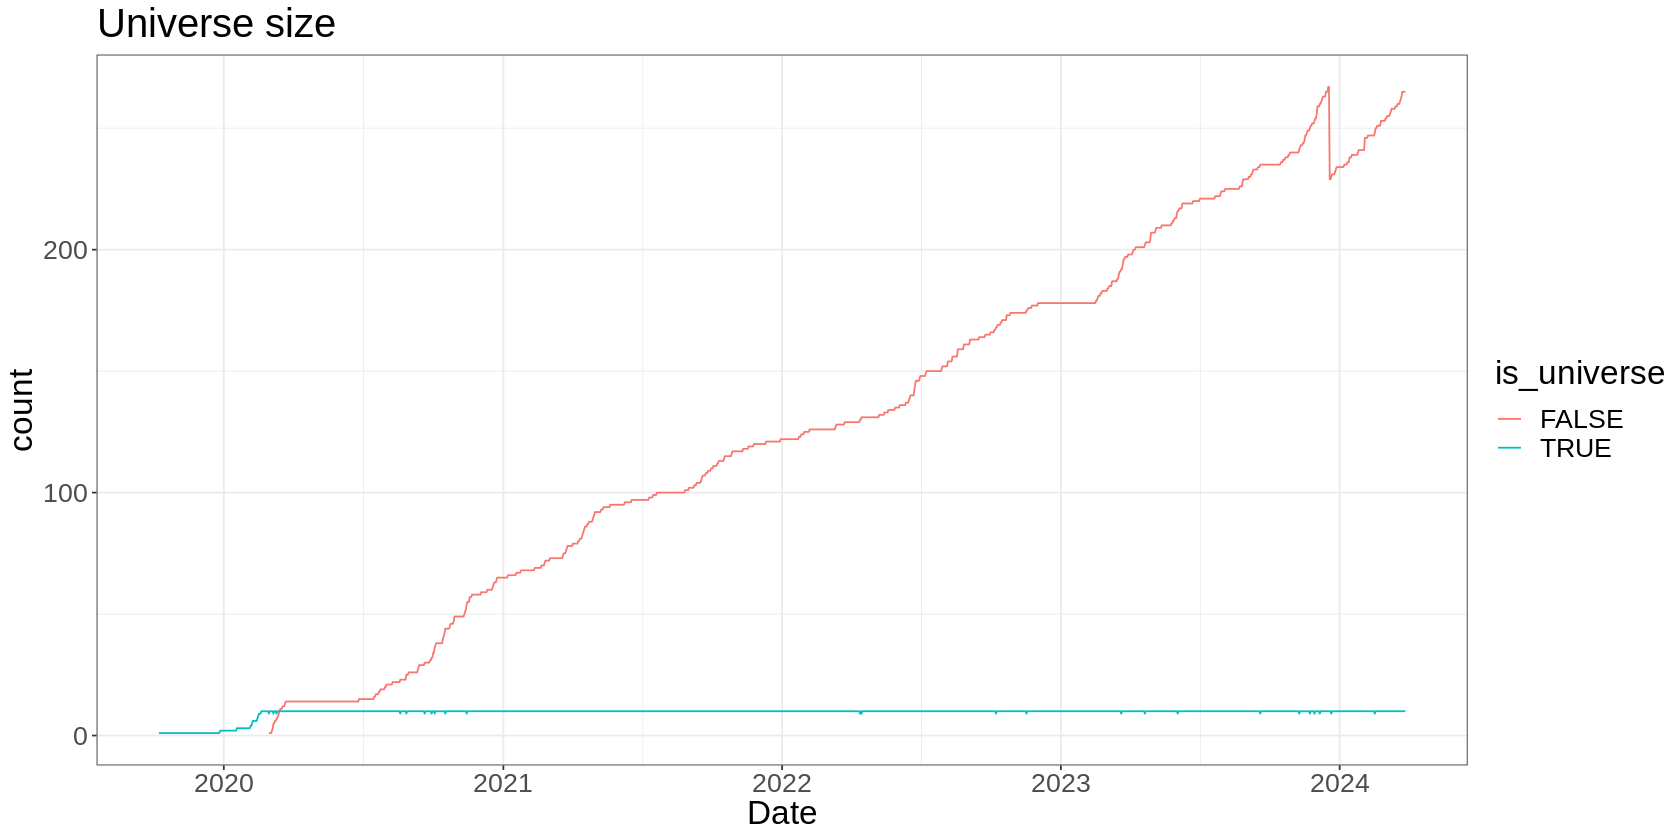

In [17]:
# demo: simulation of the carry factor with and without funding accrual

trading_universe_size <- 10

# universe: top n by trailing volume, no stables, with carry factor
universe <- daily %>%
  # remove stablecoins
  filter(!Ticker %in% glue::glue("{stables}USDT")) %>%
  # just get the top 10 by trailing 30-day volume
  group_by(Ticker) %>%
  mutate(trail_volume = roll_mean(dollar_volume, 30)) %>%
  na.omit() %>%
  group_by(Date) %>%
  mutate(
    volume_rank = row_number(-trail_volume),
    is_universe = volume_rank <= trading_universe_size
  ) %>%
    # carry factor
  group_by(Ticker) %>%
  arrange(Date) %>%
  mutate(carry_factor = lag(funding_rate)) %>%
  ungroup() %>%
  na.omit()

universe %>%
  group_by(Date, is_universe) %>%
  summarize(count = n(), .groups = "drop") %>%
  ggplot(aes(x=Date, y=count, color = is_universe)) +
  geom_line() +
  labs(
    title = 'Universe size'
)

In [18]:
# start simulation from date we first have n tickers in the universe
start_date <- universe %>%
  group_by(Date, is_universe) %>%
  summarize(count = n(), .groups = "drop") %>%
  filter(count >= trading_universe_size) %>%
  head(1) %>%
  pull(Date)

In [19]:
# calculate weights for backtesting

# filter on is_universe so that we calculate features only for stuff that's in the universe today
# (we'd have to do this differently if any of these calcs depended on past data, eg if we were doing z-score smoothing)
# then, join on original prices for backtesting so that we have prices the day before/after something dropped out of or came into the universe

# tickers that were ever in the universe
universe_tickers <- universe %>%
  filter(is_universe) %>%
  pull(Ticker) %>%
  unique()

backtest_df <- universe %>%
  filter(is_universe) %>%
  group_by(Date) %>%
  mutate(
    carry_decile = ntile(carry_factor, 10),
    carry_weight = (carry_decile - 5.5),  # will run -4.5 to 4.5
    # scale weights so that abs values sum to 1 - no leverage condition
    scaled_weight = carry_weight/sum(abs(carry_weight))
  )  %>%
  select(Date, Ticker, scaled_weight) %>%
  # join back onto df of prices for all tickers that were ever in the universe
  # so that we have prices before and after a ticker comes into or out of the universe
  # for backtesting purposes
  right_join(
    universe %>%
      filter(Ticker %in% universe_tickers) %>%
      select(Date, Ticker, close, funding_rate),
    by = c("Date", "Ticker")
  ) %>%
  # give anything with a NA weight (due to the join) a zero
  replace_na(list(scaled_weight = 0, funding_rate = 0)) %>%
  arrange(Date, Ticker) %>%
  ungroup() %>%
  # remove rows prior to start date of simulation
  filter(Date >= start_date)

tail(backtest_df)

Date,Ticker,scaled_weight,close,funding_rate
<date>,<chr>,<dbl>,<dbl>,<dbl>
2024-03-27,WLDUSDT,0.00,8.59730,-0.00053366
2024-03-27,XLMUSDT,0.00,0.13438,-0.00019656
2024-03-27,XRPUSDT,0.18,0.61630,-0.00023616
2024-03-27,XTZUSDT,0.00,1.36600,-0.00010000
2024-03-27,YFIUSDT,0.00,8807.00000,-0.00032966
2024-03-27,ZILUSDT,0.00,0.03527,-0.00050353


In [20]:
# get weights as a wide matrix
# note that date column will get converted to unix timestamp
backtest_weights <- backtest_df %>%
  pivot_wider(id_cols = Date, names_from = Ticker, values_from = c(close, scaled_weight)) %>%  # pivot wider guarantees prices and weights are date aligned
  select(Date, starts_with("scaled_weight")) %>%
  data.matrix()

# NA weights should be zero
backtest_weights[is.na(backtest_weights)] <- 0

head(backtest_weights, c(5, 5))

# get prices as a wide matrix
# note that date column will get converted to unix timestamp
backtest_prices <- backtest_df %>%
  pivot_wider(id_cols = Date, names_from = Ticker, values_from = c(close, scaled_weight)) %>%  # pivot wider guarantees prices and weights are date aligned
  select(Date, starts_with("close_")) %>%
  data.matrix()

head(backtest_prices, c(5, 5))

# get funding as a wide matrix
# note that date column will get converted to unix timestamp
backtest_funding <- backtest_df %>%
  pivot_wider(id_cols = Date, names_from = Ticker, values_from = c(close, funding_rate)) %>%  # pivot wider guarantees prices and funding_returns_simple are date aligned
  select(Date, starts_with("funding_rate_")) %>%
  data.matrix()

# NA funding reates should be zero
backtest_funding[is.na(backtest_funding)] <- 0

head(backtest_funding, c(5, 5))

Date,scaled_weight_BCHUSDT,scaled_weight_BTCUSDT,scaled_weight_EOSUSDT,scaled_weight_ETCUSDT
18311,-0.10,0.06,-0.06,0.18
18312,-0.10,0.10,0.14,0.02
18313,-0.14,-0.02,-0.06,0.02
18314,-0.10,-0.02,-0.06,0.02
18315,-0.06,-0.10,-0.02,0.02


Date,close_BCHUSDT,close_BTCUSDT,close_EOSUSDT,close_ETCUSDT
18311,378.61,9593.65,3.980,8.812
18312,370.97,9601.99,4.000,8.872
18313,378.45,9681.39,4.055,9.428
18314,373.41,9659.20,4.106,9.497
18315,402.06,9943.12,4.385,9.751


Date,funding_rate_BCHUSDT,funding_rate_BTCUSDT,funding_rate_EOSUSDT,funding_rate_ETCUSDT
18311,-0.00218112,-0.00089244,-0.00047110,-0.00109328
18312,-0.00099777,-0.00030000,-0.00039257,-0.00030000
18313,-0.00054741,-0.00030000,-0.00041537,-0.00030000
18314,-0.00036606,-0.00051906,-0.00030000,-0.00030000
18315,-0.00057082,-0.00153092,-0.00059860,-0.00139736


In [21]:
# cost-free, no trade buffer
# simulation parameters
initial_cash <- 10000
capitalise_profits <- FALSE  # remain fully invested?
trade_buffer <- 0.
commission_pct <- 0.  # 0.0015
margin <- 0.05

# simulation
results_df <- fixed_commission_backtest_with_funding(
  prices = backtest_prices,
  target_weights = backtest_weights,
  funding_rates = backtest_funding,
  trade_buffer = trade_buffer,
  initial_cash = initial_cash,
  margin = margin,
  commission_pct = commission_pct,
  capitalise_profits = capitalise_profits
  ) %>%
  mutate(ticker = str_remove(ticker, "close_")) %>%
  # remove coins we don't trade from results
  drop_na(Value)

tail(results_df, 10)

ticker,Date,Close,Position,Value,Margin,Funding,PeriodPnL,Trades,TradeValue,Commission,MarginCall,ReducedTargetPos
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LOOMUSDT,2024-03-27,1.18860e-01,0.000000e+00,0.00,0,0.000000,0.0000,0.00000000,0.000,0,0,0
GASUSDT,2024-03-27,7.10500e+00,0.000000e+00,0.00,0,0.000000,0.0000,0.00000000,0.000,0,0,0
TIAUSDT,2024-03-27,1.35708e+01,0.000000e+00,0.00,0,0.000000,0.0000,0.00000000,0.000,0,0,0
MEMEUSDT,2024-03-27,3.70480e-02,0.000000e+00,0.00,0,0.000000,0.0000,0.00000000,0.000,0,0,0
ORDIUSDT,2024-03-27,6.22980e+01,0.000000e+00,0.00,0,0.000000,0.0000,0.00000000,0.000,0,0,0
1000BONKUSDT,2024-03-27,2.51350e-02,0.000000e+00,0.00,0,0.000000,0.0000,0.00000000,0.000,0,0,0
BTCUSDC,2024-03-27,6.88940e+04,-2.903010e-03,-200.00,10,0.000000,0.0000,-0.00290301,-200.000,0,0,0
MANTAUSDT,2024-03-27,3.08360e+00,0.000000e+00,0.00,0,0.000000,0.0000,0.00000000,0.000,0,0,0
WIFUSDT,2024-03-27,3.03270e+00,-5.935305e+02,-1800.00,90,2.006276,123.4933,-40.05902114,-121.487,0,0,0


In [22]:
# our equity is our cash balance plus our margin
margin <- results_df %>%
  group_by(Date) %>%
  summarise(Margin = sum(Margin, na.rm = TRUE))

cash_balance <- results_df %>%
  filter(ticker == "Cash") %>%
  select(Date, Value) %>%
  rename("Cash" = Value)

equity <- cash_balance %>%
  left_join(margin, by = "Date") %>%
  mutate(Equity = Cash + Margin)

head(equity)

Date,Cash,Margin,Equity
<date>,<dbl>,<dbl>,<dbl>
2020-02-19,9500.000,500.0000,10000.000
2020-02-20,9568.234,500.0000,10068.234
2020-02-21,9510.692,500.0000,10010.692
2020-02-22,9451.013,497.4217,9948.435
2020-02-23,9436.604,496.6633,9933.267
2020-02-24,9339.255,491.5397,9830.795


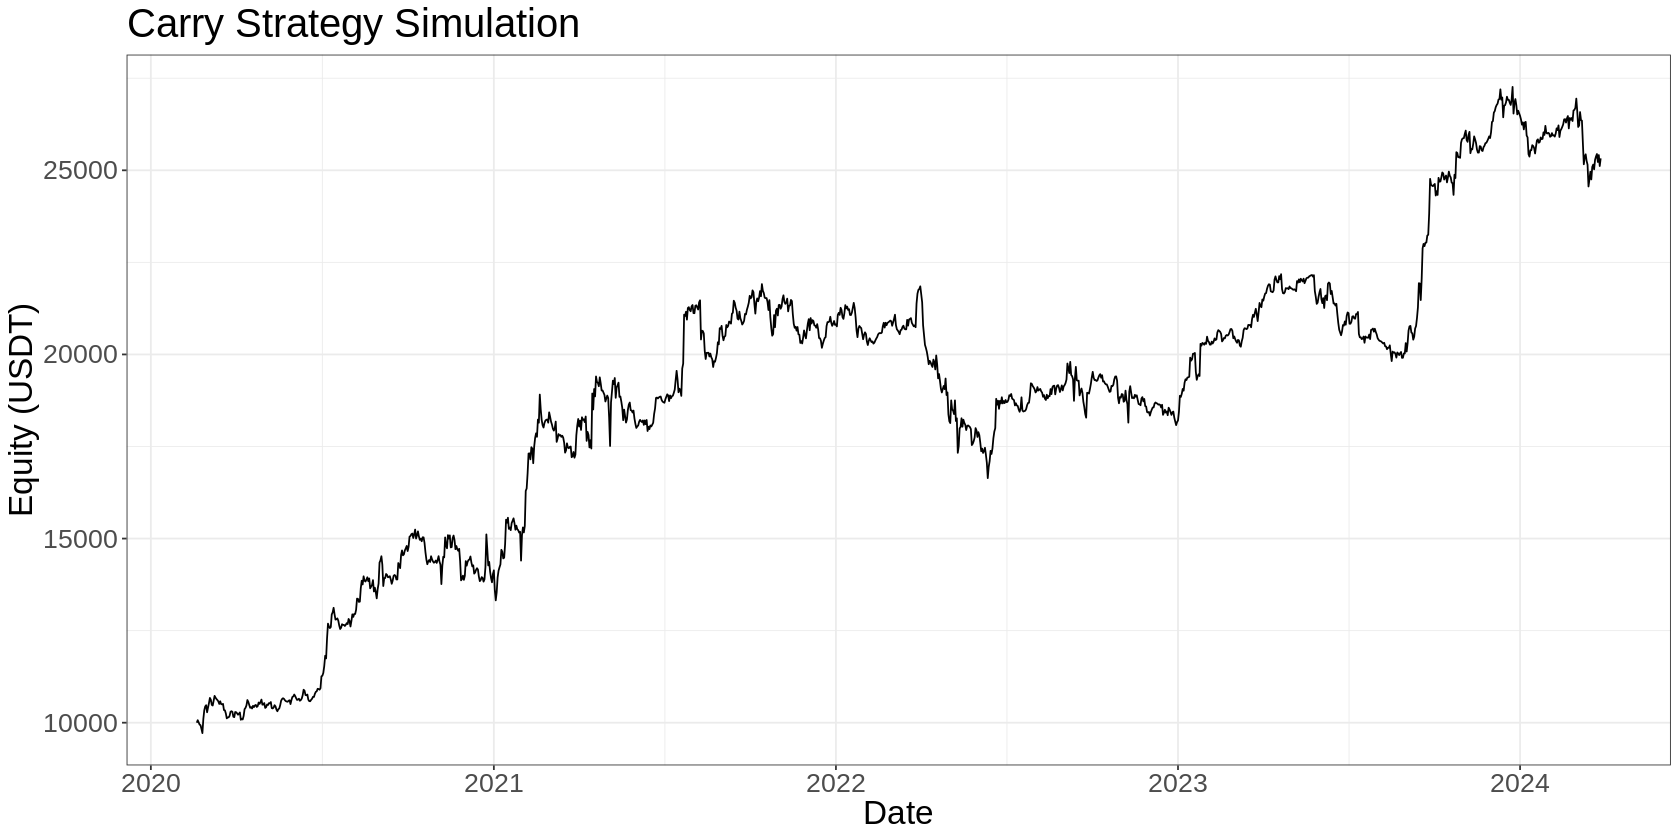

In [23]:
# plot
equity %>%
  ggplot(aes(x = Date, y = Equity)) +
    geom_line() +
    labs(
      y = "Equity (USDT)",
      title = "Carry Strategy Simulation"
    )

In [24]:
# make a nice plot with some summary statistics
# plot equity curve from output of simulation
plot_results <- function(backtest_results, trade_on = "close") {
  margin <- backtest_results %>%
    group_by(Date) %>%
    summarise(Margin = sum(Margin, na.rm = TRUE))

  cash_balance <- backtest_results %>%
    filter(ticker == "Cash") %>%
    select(Date, Value) %>%
    rename("Cash" = Value)

  equity <- cash_balance %>%
    left_join(margin, by = "Date") %>%
    mutate(Equity = Cash + Margin)

  fin_eq <- equity %>%
    tail(1) %>%
    pull(Equity)

  init_eq <- equity %>%
    head(1) %>%
    pull(Equity)

  total_return <- (fin_eq/init_eq - 1) * 100
  days <- nrow(equity)
  ann_return <- total_return * 365/days
  sharpe <- equity %>%
    mutate(returns = Equity/lag(Equity)- 1) %>%
    na.omit() %>%
    summarise(sharpe = sqrt(365)*mean(returns)/sd(returns)) %>%
    pull()

  equity %>%
    ggplot(aes(x = Date, y = Equity)) +
      geom_line() +
      labs(
        title = "Carry Strategy Simulation",
        subtitle = glue::glue(
          "Carry factor trading strategy simulation, costs {commission_pct*100}% of trade value, trade buffer = {trade_buffer}, trade on {trade_on}
          {round(total_return, 1)}% total return, {round(ann_return, 1)}% annualised, Sharpe {round(sharpe, 2)}"
        )
      )
}

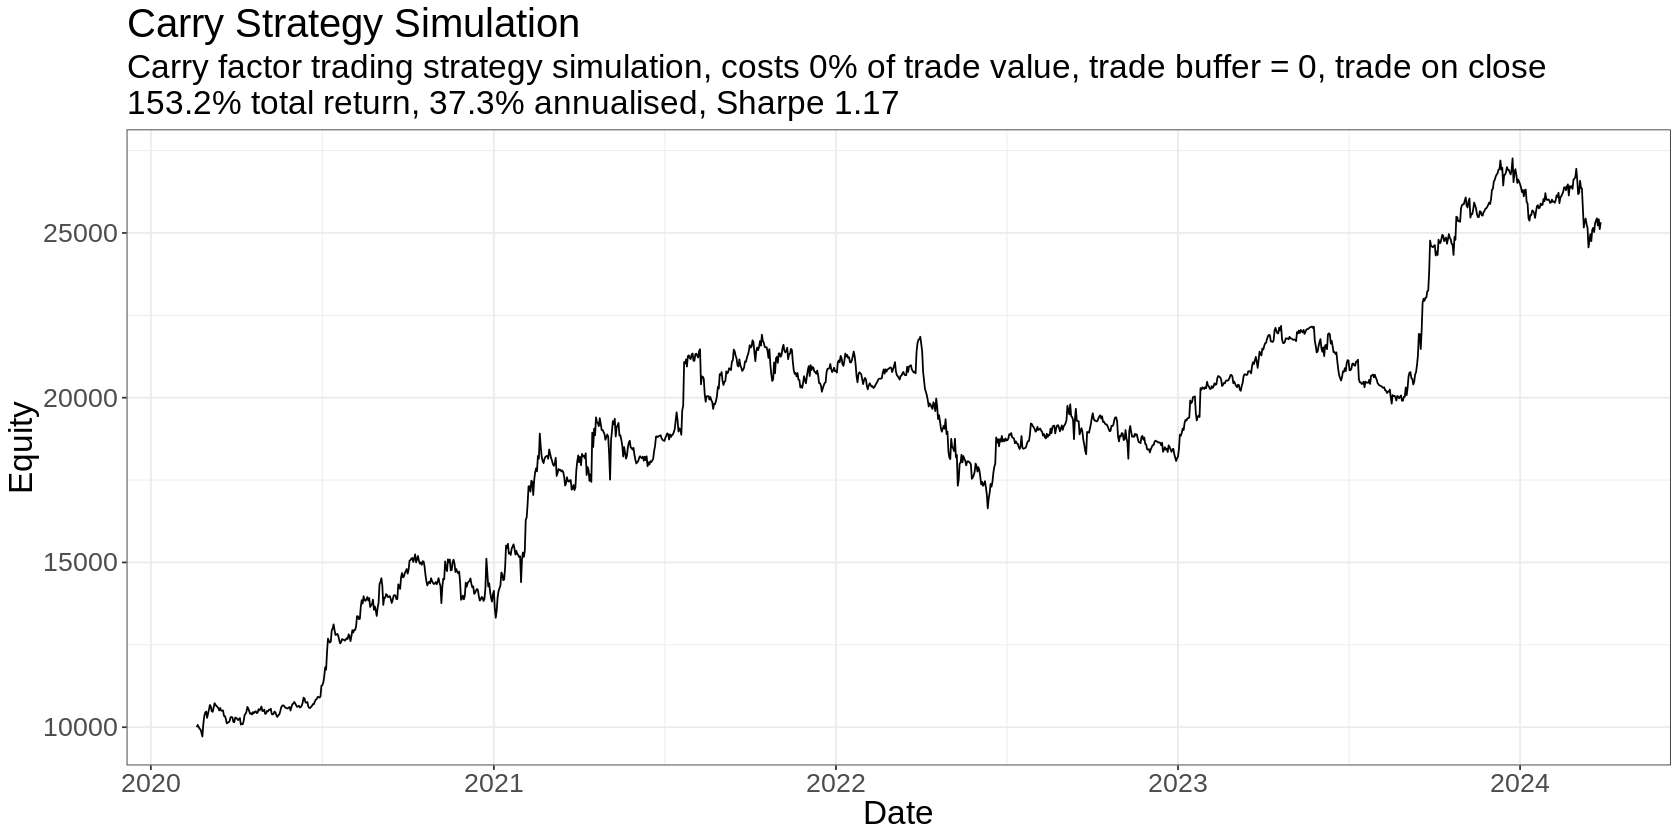

In [25]:
plot_results(results_df)

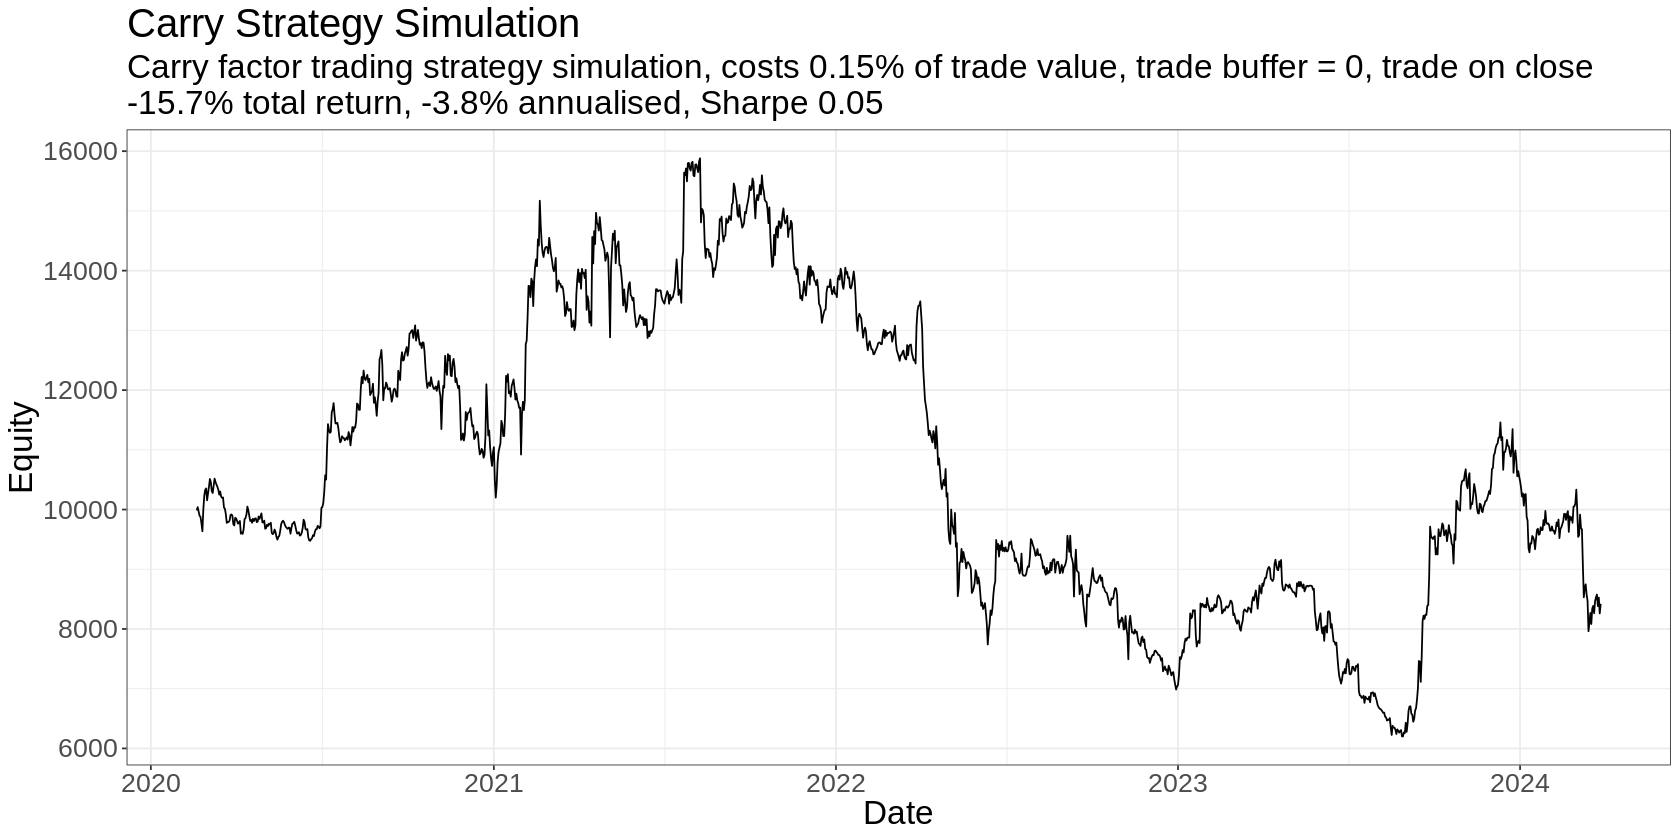

In [26]:
# impact of costs
# no trade buffer
# simulation parameters
initial_cash <- 10000
capitalise_profits <- FALSE  # remain fully invested?
trade_buffer <- 0.
commission_pct <- 0.0015
margin <- 0.05

# simulation
results_df <- fixed_commission_backtest_with_funding(
  prices = backtest_prices,
  target_weights = backtest_weights,
  funding_rates = backtest_funding,
  trade_buffer = trade_buffer,
  initial_cash = initial_cash,
  margin = margin,
  commission_pct = commission_pct,
  capitalise_profits = capitalise_profits
  ) %>%
  mutate(ticker = str_remove(ticker, "close_")) %>%
  # remove coins we don't trade from results
  drop_na(Value)

plot_results(results_df)

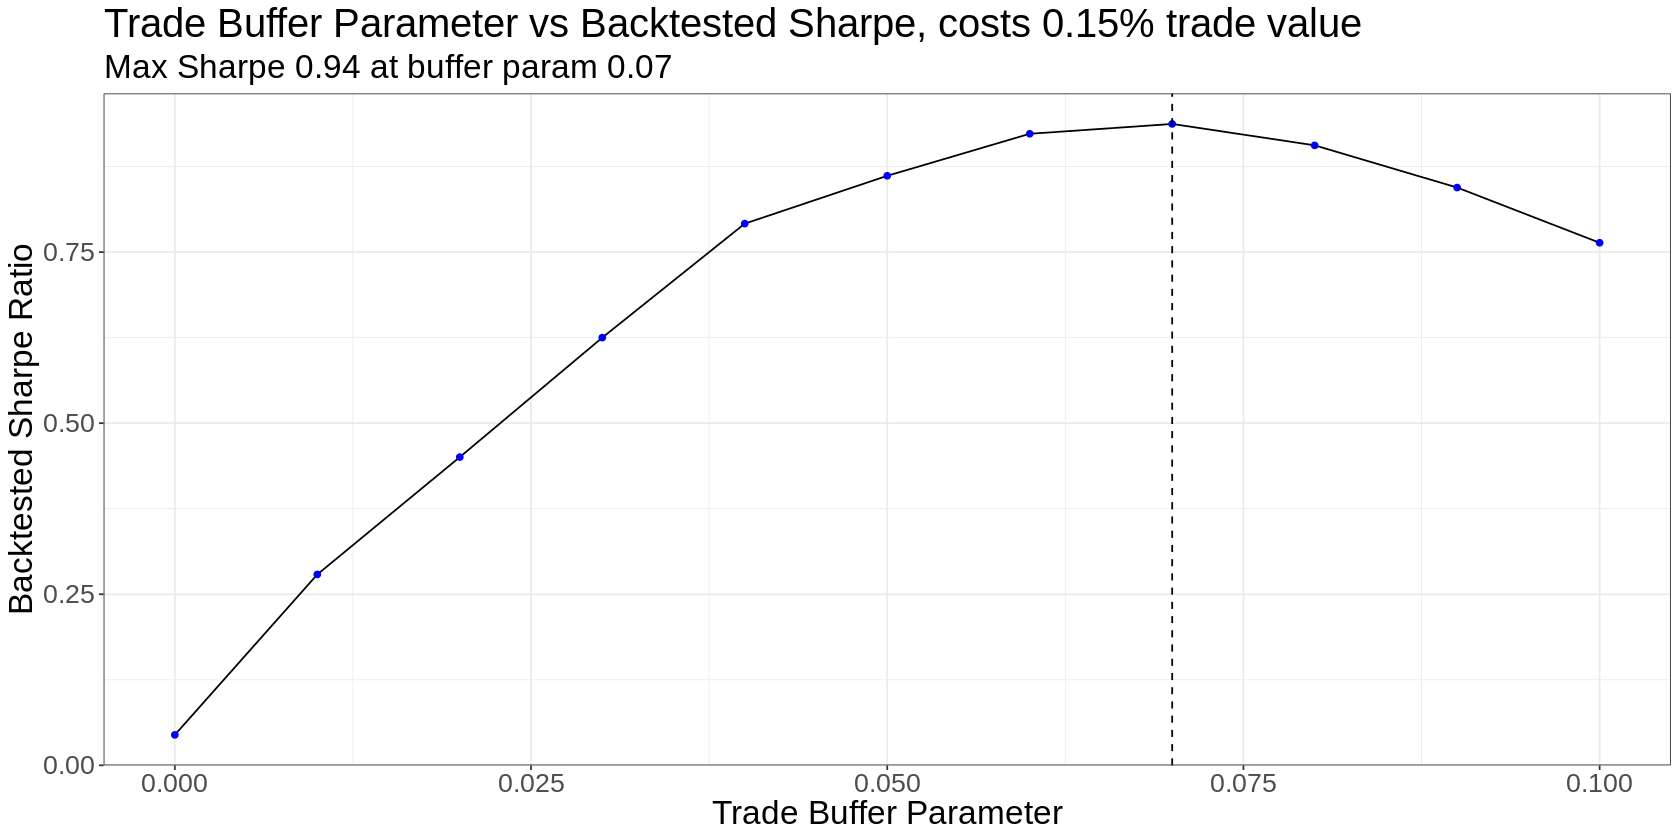

In [27]:
# calculate sharpe ratio from output of simulation
calc_sharpe <- function(backtest_results) {
  margin <- backtest_results %>%
    group_by(Date) %>%
    summarise(Margin = sum(Margin, na.rm = TRUE))

  cash_balance <- backtest_results %>%
    filter(ticker == "Cash") %>%
    select(Date, Value) %>%
    rename("Cash" = Value)

  equity <- cash_balance %>%
    left_join(margin, by = "Date") %>%
    mutate(Equity = Cash + Margin)

equity %>%
    mutate(returns = Equity/lag(Equity)- 1) %>%
    na.omit() %>%
    summarise(sharpe = sqrt(355)*mean(returns)/sd(returns)) %>%
    pull()
}

# find appropriate trade buffer by optimising historical sharpe
sharpes <- list()
trade_buffers <- seq(0, 0.1, by = 0.01)
for(trade_buffer in trade_buffers) {
  sharpes <- c(
    sharpes,
    fixed_commission_backtest_with_funding(
      prices = backtest_prices,
      target_weights = backtest_weights,
      funding_rates = backtest_funding,
      trade_buffer = trade_buffer,
      initial_cash = initial_cash,
      margin = margin,
      commission_pct = commission_pct,
      capitalise_profits = capitalise_profits
      ) %>%
      calc_sharpe()
  )
}

sharpes <- unlist(sharpes)
data.frame(
  trade_buffer = trade_buffers,
  sharpe = sharpes
) %>%
  ggplot(aes(x = trade_buffer, y = sharpe)) +
    geom_line() +
    geom_point(colour = "blue") +
    geom_vline(xintercept = trade_buffers[which.max(sharpes)], linetype = "dashed") +
    labs(
      x = "Trade Buffer Parameter",
      y = "Backtested Sharpe Ratio",
      title = glue::glue("Trade Buffer Parameter vs Backtested Sharpe, costs {commission_pct*100}% trade value"),
      subtitle = glue::glue("Max Sharpe {round(max(sharpes), 2)} at buffer param {trade_buffers[which.max(sharpes)]}")
    )

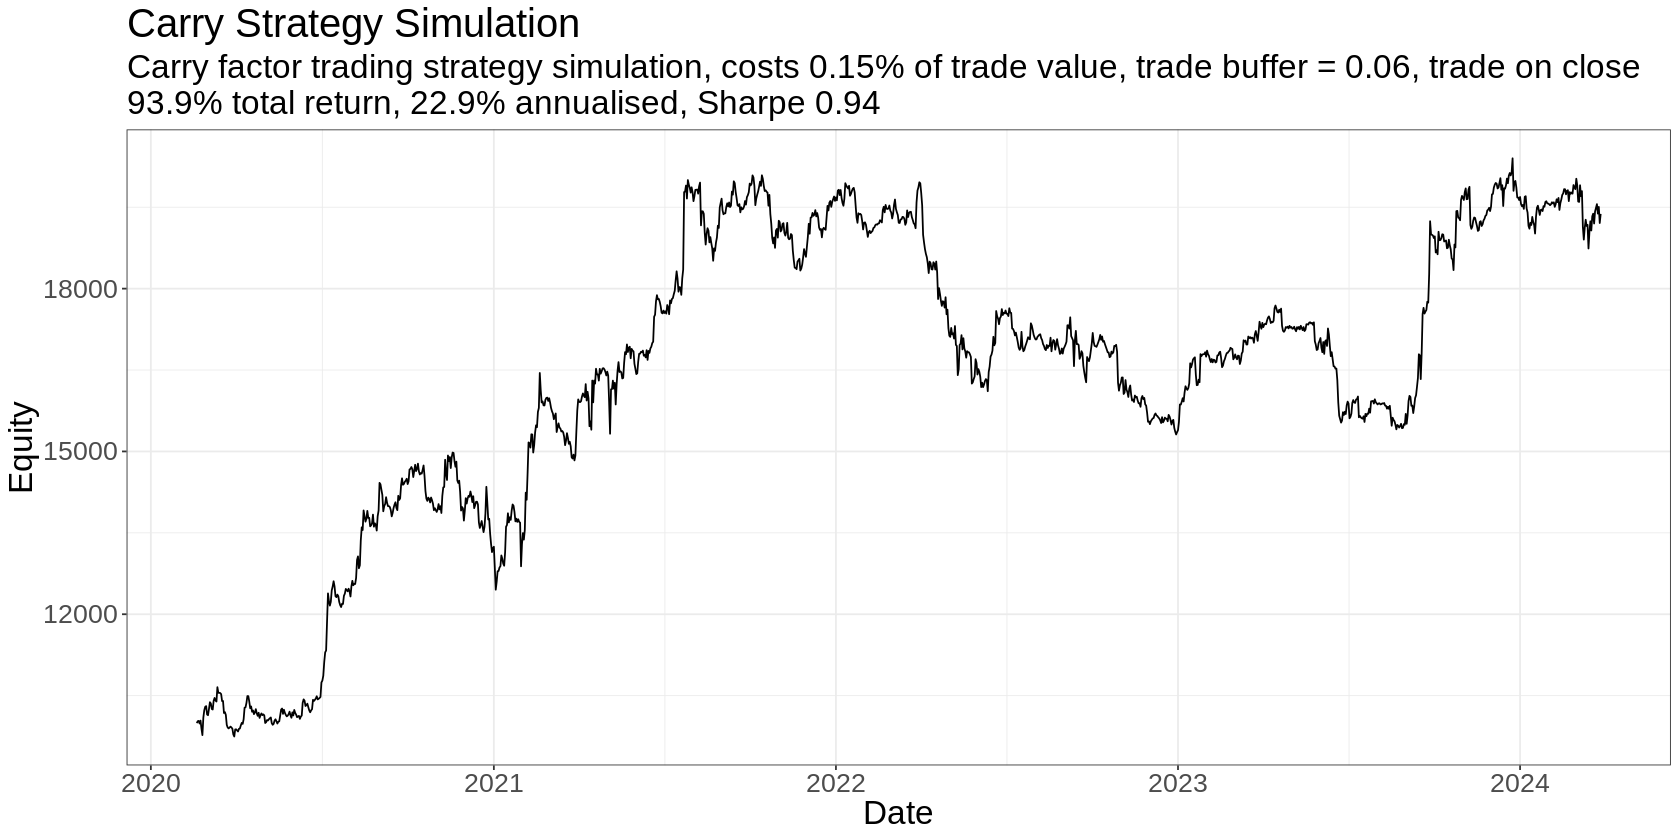

In [28]:
# impact of costs - use a trade buffer
# simulation parameters
initial_cash <- 10000
capitalise_profits <- FALSE  # remain fully invested?
trade_buffer <- 0.06
commission_pct <- 0.0015
margin <- 0.05

# simulation
results_df <- fixed_commission_backtest_with_funding(
  prices = backtest_prices,
  target_weights = backtest_weights,
  funding_rates = backtest_funding,
  trade_buffer = trade_buffer,
  initial_cash = initial_cash,
  margin = margin,
  commission_pct = commission_pct,
  capitalise_profits = capitalise_profits
  ) %>%
  mutate(ticker = str_remove(ticker, "close_")) %>%
  # remove coins we don't trade from results
  drop_na(Value)

plot_results(results_df)

In [29]:
# impact of a broader universe

trading_universe_size <- 30

# universe: top n by trailing volume, no stables, with carry factor
universe <- daily %>%
  # remove stablecoins
  filter(!Ticker %in% glue::glue("{stables}USDT")) %>%
  # just get the top 10 by trailing 30-day volume
  group_by(Ticker) %>%
  mutate(trail_volume = roll_mean(dollar_volume, 30)) %>%
  na.omit() %>%
  group_by(Date) %>%
  mutate(
    volume_rank = row_number(-trail_volume),
    is_universe = volume_rank <= trading_universe_size
  ) %>%
    # carry factor
  group_by(Ticker) %>%
  arrange(Date) %>%
  mutate(carry_factor = lag(funding_rate)) %>%
  ungroup() %>%
  na.omit()

# start simulation from date we first have n tickers in the universe
start_date <- universe %>%
  group_by(Date, is_universe) %>%
  summarize(count = n(), .groups = "drop") %>%
  filter(count >= trading_universe_size) %>%
  head(1) %>%
  pull(Date)

# calculate weights for backtesting

# filter on is_universe so that we calculate features only for stuff that's in the universe today
# (we'd have to do this differently if any of these calcs depended on past data, eg if we were doing z-score smoothing)
# then, join on original prices for backtesting so that we have prices the day before/after something dropped out of or came into the universe

# tickers that were ever in the universe
universe_tickers <- universe %>%
  filter(is_universe) %>%
  pull(Ticker) %>%
  unique()

backtest_df <- universe %>%
  filter(is_universe) %>%
  group_by(Date) %>%
  mutate(
    carry_decile = ntile(carry_factor, 10),
    carry_weight = (carry_decile - 5.5),  # will run -4.5 to 4.5
    # scale weights so that abs values sum to 1 - no leverage condition
    scaled_weight = carry_weight/sum(abs(carry_weight))
  )  %>%
  select(Date, Ticker, scaled_weight) %>%
  # join back onto df of prices for all tickers that were ever in the universe
  # so that we have prices before and after a ticker comes into or out of the universe
  # for backtesting purposes
  right_join(
    universe %>%
      filter(Ticker %in% universe_tickers) %>%
      select(Date, Ticker, close, funding_rate),
    by = c("Date", "Ticker")
  ) %>%
  # give anything with a NA weight (due to the join) a zero
  replace_na(list(scaled_weight = 0, funding_rate = 0)) %>%
  arrange(Date, Ticker) %>%
  ungroup() %>%
  # remove rows prior to start date of simulation
  filter(Date >= start_date)

# get weights as a wide matrix
# note that date column will get converted to unix timestamp
backtest_weights <- backtest_df %>%
  pivot_wider(id_cols = Date, names_from = Ticker, values_from = c(close, scaled_weight)) %>%  # pivot wider guarantees prices and weights are date aligned
  select(Date, starts_with("scaled_weight")) %>%
  data.matrix()

# NA weights should be zero
backtest_weights[is.na(backtest_weights)] <- 0

# get prices as a wide matrix
# note that date column will get converted to unix timestamp
backtest_prices <- backtest_df %>%
  pivot_wider(id_cols = Date, names_from = Ticker, values_from = c(close, scaled_weight)) %>%  # pivot wider guarantees prices and weights are date aligned
  select(Date, starts_with("close_")) %>%
  data.matrix()

# get funding as a wide matrix
# note that date column will get converted to unix timestamp
backtest_funding <- backtest_df %>%
  pivot_wider(id_cols = Date, names_from = Ticker, values_from = c(close, funding_rate)) %>%  # pivot wider guarantees prices and funding_returns_simple are date aligned
  select(Date, starts_with("funding_rate_")) %>%
  data.matrix()

# NA funding reates should be zero
backtest_funding[is.na(backtest_funding)] <- 0

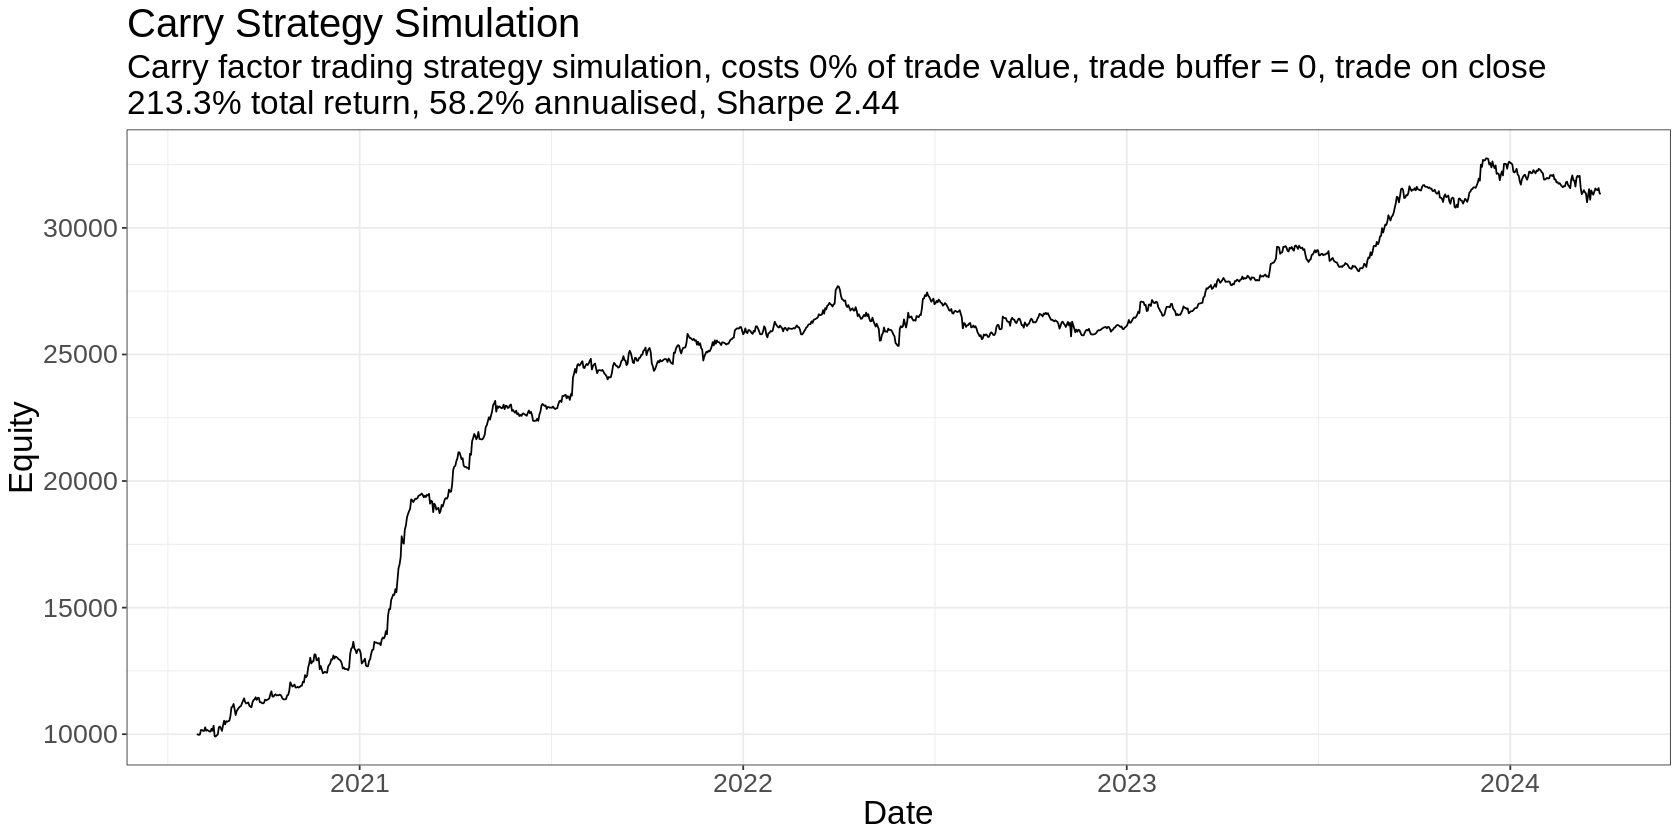

In [30]:
# cost-free, no trade buffer
# simulation parameters
initial_cash <- 10000
capitalise_profits <- FALSE  # remain fully invested?
trade_buffer <- 0.
commission_pct <- 0.
margin <- 0.05

# simulation
results_df <- fixed_commission_backtest_with_funding(
  prices = backtest_prices,
  target_weights = backtest_weights,
  funding_rates = backtest_funding,
  trade_buffer = trade_buffer,
  initial_cash = initial_cash,
  margin = margin,
  commission_pct = commission_pct,
  capitalise_profits = capitalise_profits
  ) %>%
  mutate(ticker = str_remove(ticker, "close_")) %>%
  # remove coins we don't trade from results
  drop_na(Value)

plot_results(results_df)

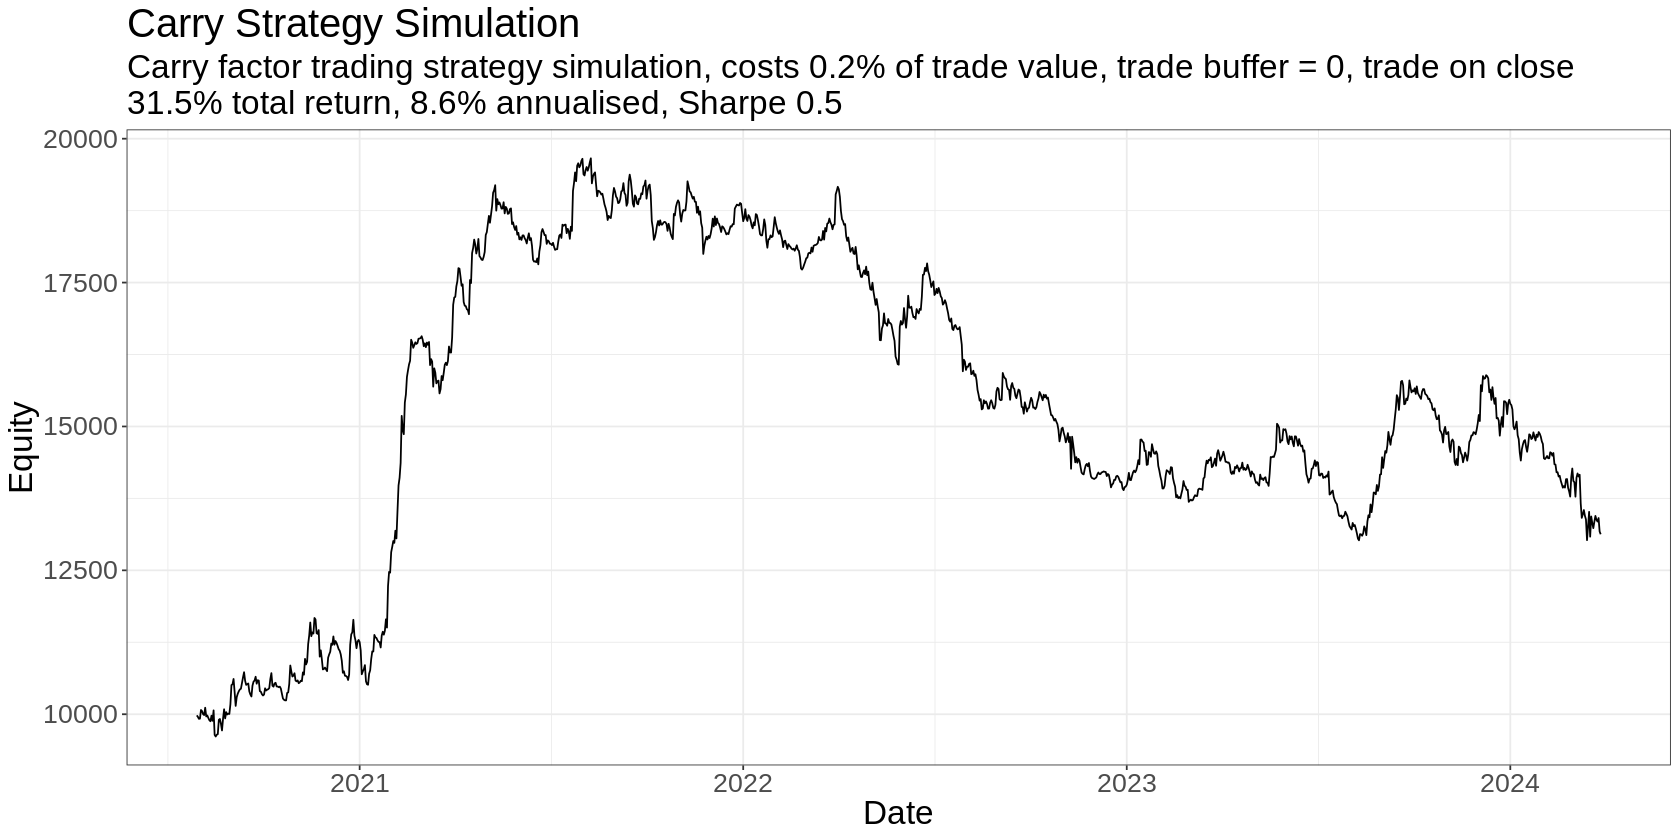

In [31]:
# impact of costs
# no trade buffer
# simulation parameters
initial_cash <- 10000
capitalise_profits <- FALSE  # remain fully invested?
trade_buffer <- 0.
commission_pct <- 0.002  #### NOTE: costs higher
margin <- 0.05

# simulation
results_df <- fixed_commission_backtest_with_funding(
  prices = backtest_prices,
  target_weights = backtest_weights,
  funding_rates = backtest_funding,
  trade_buffer = trade_buffer,
  initial_cash = initial_cash,
  margin = margin,
  commission_pct = commission_pct,
  capitalise_profits = capitalise_profits
  ) %>%
  mutate(ticker = str_remove(ticker, "close_")) %>%
  # remove coins we don't trade from results
  drop_na(Value)

plot_results(results_df)

Warning message:
“Removed 4 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”


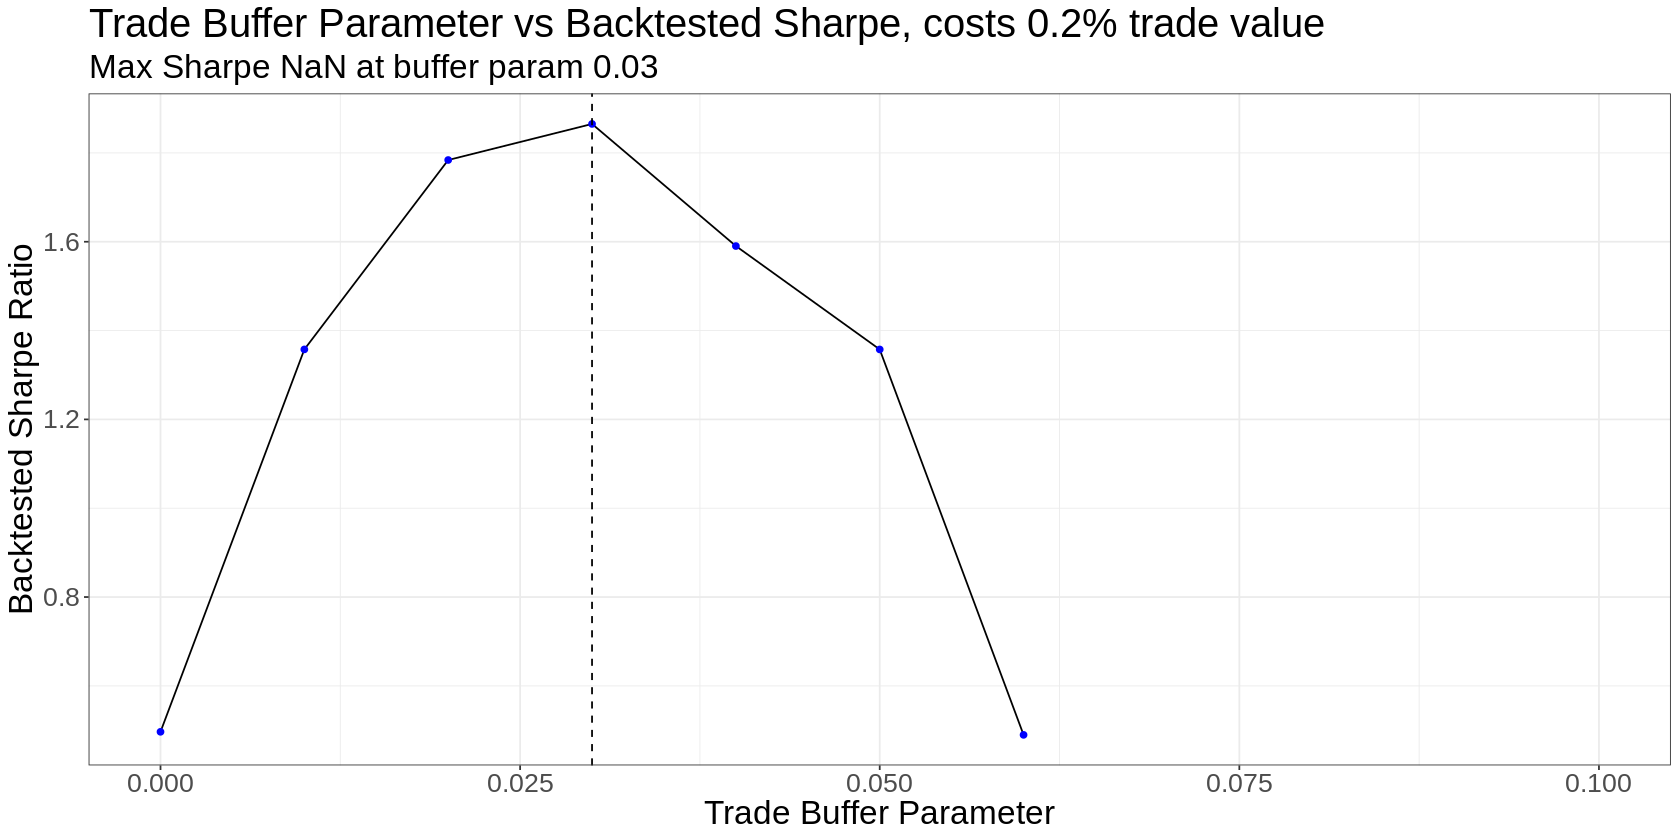

In [32]:
# find appropriate trade buffer by optimising historical sharpe
sharpes <- list()
trade_buffers <- seq(0, 0.1, by = 0.01)
for(trade_buffer in trade_buffers) {
  sharpes <- c(
    sharpes,
    fixed_commission_backtest_with_funding(
      prices = backtest_prices,
      target_weights = backtest_weights,
      funding_rates = backtest_funding,
      trade_buffer = trade_buffer,
      initial_cash = initial_cash,
      margin = margin,
      commission_pct = commission_pct,
      capitalise_profits = capitalise_profits
      ) %>%
      calc_sharpe()
  )
}

sharpes <- unlist(sharpes)
data.frame(
  trade_buffer = trade_buffers,
  sharpe = sharpes
) %>%
  ggplot(aes(x = trade_buffer, y = sharpe)) +
    geom_line() +
    geom_point(colour = "blue") +
    geom_vline(xintercept = trade_buffers[which.max(sharpes)], linetype = "dashed") +
    labs(
      x = "Trade Buffer Parameter",
      y = "Backtested Sharpe Ratio",
      title = glue::glue("Trade Buffer Parameter vs Backtested Sharpe, costs {commission_pct*100}% trade value"),
      subtitle = glue::glue("Max Sharpe {round(max(sharpes), 2)} at buffer param {trade_buffers[which.max(sharpes)]}")
    )

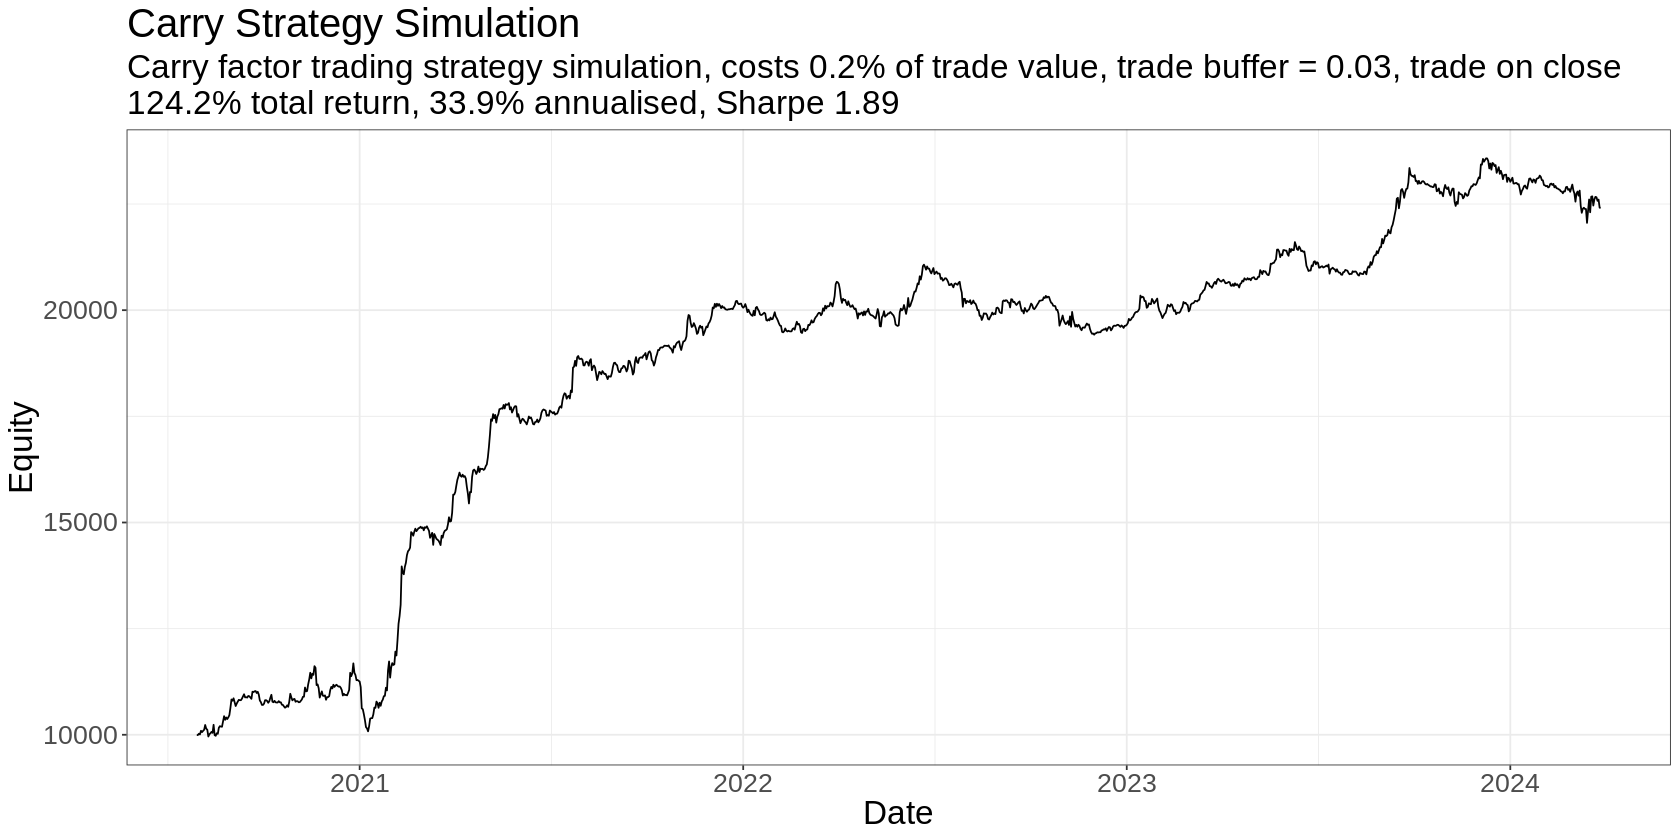

In [33]:
# impact of costs - use a trade buffer
# simulation parameters
initial_cash <- 10000
capitalise_profits <- FALSE  # remain fully invested?
trade_buffer <- 0.03
commission_pct <- 0.002
margin <- 0.05

# simulation
results_df <- fixed_commission_backtest_with_funding(
  prices = backtest_prices,
  target_weights = backtest_weights,
  funding_rates = backtest_funding,
  trade_buffer = trade_buffer,
  initial_cash = initial_cash,
  margin = margin,
  commission_pct = commission_pct,
  capitalise_profits = capitalise_profits
  ) %>%
  mutate(ticker = str_remove(ticker, "close_")) %>%
  # remove coins we don't trade from results
  drop_na(Value)

plot_results(results_df)